In [1]:
from tensorflow.keras.datasets import reuters
import pandas as pd
import numpy as np
import time
from tensorflow import keras
from tensorflow.keras import layers

import os
from dotenv import load_dotenv
from utils.utils import TopicNeuralNet
pd.set_option('display.max_colwidth', None)

In [2]:
path = "./data/"

In [3]:
ls data

1.crypto_apps_reviews_raw.csv
1.crypto_category.txt
2.crypto_app_reviews_tagged.csv
3.tagged_reviews_sample.csv
4.tagged_reviews_sample_llm_verified.csv
4.tagged_reviews_sample_verified.csv
co.mona.android.csv
com.binance.dev.csv
com.bybit.app.csv
crypt_app_llm_tagged.csv
crypto_app_llm_tagged.csv
final_report_rubric_v2.pdf


In [4]:
df_r = pd.read_csv(path+"/4.tagged_reviews_sample_verified.csv")

## Train test split

In [5]:
review_col = "content"
target_col = "gemini_llm_topic"

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
df_r.shape

(299, 17)

In [8]:
X = df_r
y = df_r[target_col]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

#split text and labels
train_sentences = X_train[review_col].to_numpy()
train_labels = y_train.to_numpy()
test_sentences = X_test[review_col].to_numpy()
test_labels = y_test.to_numpy()

In [10]:
def remove_sparse_labels(train_labels, test_labels):
    """
    Removes obsevations from the test sets when the corresponding label does not exist in the train set.
    Since a random sample was performed, this only samples who´s label has lo prevalence would be removed.
    Removing these make sense since it would impact the model´s performance (because this instances are rare).
    """
    unique_labels = np.unique(train_labels)
    keep_index = []
    for label in test_labels:
        if label in unique_labels:
            keep_index.append(True)
        else:
            keep_index.append(False)
    return keep_index

In [11]:
keep = remove_sparse_labels(train_labels, test_labels)

In [12]:
X_test = X_test[keep]
y_test = y_test[keep]
test_sentences = test_sentences[keep]
test_labels = test_labels[keep]

In [13]:
X_train.head(2)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,app,gemini_llm_topic,correct,human_labeled_topic,cause,corrected_topic
6,b0ffcb5d-fd04-4e92-a16b-d9d182682abc,Igor Andreevski,https://play-lh.googleusercontent.com/a-/ALV-UjVtnSstDY1JMgNB-eI4Gc0x03Ox1I1Jin4i40aUEfqleTGdBnpc,not listing of pi network and stealing my deposits,1,0,2.96.2,2025-03-10 17:07:08,NaN,NaN,2.96.2,com.binance.dev,Wallet Security/Integration,0,Features/Functionality,"Probably the word ""stealing"" had a lot of weight.",Features/Functionality
183,5868700d-ef14-4396-afec-9467b6f5ff28,mel doyle,https://play-lh.googleusercontent.com/a-/ALV-UjUDHCfjndjLBnao18X_0AaNBbPA4zrrJG6vgIetsnaDRx12UUEM,Unable to use card,2,0,3.201.0,2024-12-14 9:37:41,NaN,NaN,3.201.0,co.mona.android,Usability/UI/UX,0,Features/Functionality,NaN,Features/Functionality


## Expore Tokens

In [14]:
from collections import Counter

In [39]:
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

In [40]:
counter = counter_word(df_r.content)

In [41]:
counter_lower = counter_word(df_r.content.str.lower())

The examples below are just to hint at the need of preprocessing. 

Note how with no preprocessing, the token 'the' comes up X amount times, but when we a apply a simple lower case processing, the count goes up.

This means "The" and "the" would be treated as different tokens by the neural net.

In [42]:
counter.most_common(10)

[('the', 283),
 ('to', 282),
 ('I', 190),
 ('and', 185),
 ('a', 154),
 ('is', 131),
 ('my', 122),
 ('it', 112),
 ('you', 111),
 ('app', 99)]

In [43]:
counter_lower.most_common(10)

[('the', 323),
 ('to', 286),
 ('i', 220),
 ('and', 202),
 ('a', 159),
 ('is', 135),
 ('my', 129),
 ('it', 129),
 ('you', 122),
 ('app', 109)]

In [44]:
num_unique_words = len(counter)
print(num_unique_words)

2508


## Tokenization

In [45]:
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder

In [46]:
#vectorize a text corpus by turning each text into a sequence of integers
tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(train_sentences) #fit only to the train set

In [47]:
from sklearn.preprocessing import OrdinalEncoder

#vectorize the labels
le = LabelEncoder()
le.fit(train_labels) #fit only to trainin

LabelEncoder()

In [48]:
le.inverse_transform([0])

array(['Account Management'], dtype=object)

In [49]:
#each word has a unique index
word_index = tokenizer.word_index

In [50]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

In [51]:
y_train = le.transform(train_labels)
y_test = le.transform(test_labels)

In [52]:
print("Example sequence 1:")
print(train_sentences[10:11])
print(train_sequences[10:11])
print("Example sequence 2:")
print(train_sentences[20:21])
print(train_sequences[20:21])

Example sequence 1:
['So firstly I must say support is excellent. Overall, the experience is just ok. App, particularly visa is super slow. WARNING. IF you should choose the visa card. First hand experience, when you lock in your stake, you will get staking rewards. These are a pittance compared to other staking programs.When the bear comes , they will slash those rewards , but since your investment will be down 80 to 90% , you will be trapped. Also visa transactions like hotel deposits take weeks to finalize.']
[[26, 733, 3, 283, 380, 73, 10, 381, 734, 1, 116, 10, 64, 735, 9, 736, 201, 10, 191, 164, 737, 34, 7, 170, 738, 1, 201, 53, 292, 739, 116, 25, 7, 486, 14, 19, 487, 7, 81, 27, 382, 383, 488, 39, 5, 740, 489, 2, 100, 382, 741, 25, 1, 742, 743, 17, 81, 744, 384, 383, 18, 113, 19, 745, 81, 37, 237, 293, 2, 746, 7, 81, 37, 747, 153, 201, 294, 75, 748, 471, 93, 295, 2, 749]]
Example sequence 2:
['Someone frauded with me please stay alert']
[[505, 788, 21, 22, 48, 399, 789]]


As seen above, sequences can have different lengths since the sentences may contain a distinct number of words. We need all sequences to be of the same length, and for this we will use padding.

In [53]:
#Pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

#max number of words in a sequence
max_length = 255

train_padded = pad_sequences(train_sequences, maxlen= max_length, padding = "post", truncating = "post")
test_padded = pad_sequences(test_sequences, maxlen = max_length, padding = "post", truncating = "post")
train_padded.shape, test_padded.shape

((239, 255), (60, 255))

In [54]:
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])
def decode(sequence):
    return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])

In [55]:
decoded_text = decode(train_sequences[10])

In [56]:
decoded_text

'so firstly i must say support is excellent overall the experience is just ok app particularly visa is super slow warning if you should choose the visa card first hand experience when you lock in your stake you will get staking rewards these are a pittance compared to other staking programs when the bear comes they will slash those rewards but since your investment will be down 80 to 90 you will be trapped also visa transactions like hotel deposits take weeks to finalize'

## Train model

In [57]:
num_classes = df_r["gemini_llm_topic"].nunique()

In [58]:
num_classes

12

In [59]:
df_r["gemini_llm_topic"].value_counts()

gemini_llm_topic
Usability/UI/UX                     51
Generic feedback                    50
Reliability/Stability               39
Account Management                  38
Customer Support                    36
Transaction Fees/Speed              31
Features/Functionality              25
Verification/KYC/AML Processes      16
Security                             5
Educational Resources/Onboarding     4
Wallet Security/Integration          3
Privacy                              1
Name: count, dtype: int64

In [14]:
X, y = df_r.content, df_r.corrected_topic

In [13]:
topic_model = TopicNeuralNet(X_train.content,y_train)
topic_model.fit(epochs=100, preprocess=True, bootstrapping=True)

Bootstrapping by a factor of 100
Normalizing text
Fitting text tokenizer
Fitting label tokenizer
Tokenizing text
Tokenizing labels
Passing text sequences
Setting model architecture
Compiled model
Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1506 - loss: 72.4015 - val_accuracy: 0.5594 - val_loss: 13.7196
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2744 - loss: 23.9024 - val_accuracy: 0.6027 - val_loss: 10.9700
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3681 - loss: 16.6763 - val_accuracy: 0.6740 - val_loss: 9.8935
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3967 - loss: 14.0659 - val_accuracy: 0.7347 - val_loss: 9.2613
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4256 - loss: 12.4684 - val_accuracy: 0.7589 - val_loss: 8.8379
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4683 - loss: 11.4125 - val_accuracy: 0.7432 - val_loss: 8.5991
Epoch 7/100
15/15 ━━━━━━━━━━━━━━

In [23]:
topic_model.model.evaluate(topic_model.text_sequences_padded, topic_model.label_sequences)


747/747 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - accuracy: 0.8808 - loss: 3.6499


[3.6535773277282715, 0.8775731921195984]

In [24]:
y_hat_test = topic_model.predict(X_train.content)

Normalizing text
Tokenizing text
Passing text sequences
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [27]:
pd.DataFrame({"y_test":y_train, "y_hat_test":y_hat_test, "review": X_train.content}).head(20)

,y_test,y_hat_test,review
6,Wallet Security/Integration,Wallet Security/Integration,not listing of pi network and stealing my deposits
183,Usability/UI/UX,Generic feedback,Unable to use card
185,Usability/UI/UX,Usability/UI/UX,"Well, the app is super slow, but at least it works again since the problematic update a while back. The constant ""must update to continue using the app"" is EXTREMELY annoying. I don't care if i miss 1 or 2 features, i just want to check on my crypto for once without being nagged to update. Now if an update made the app faster or better again, maybe I'd be interested. But nothing changes. This has been posted a long time, so from now on, every time I get nagged to update,this review loses a star."
146,Wallet Security/Integration,Wallet Security/Integration,I tried to withdraw Cronos to my external wallet but I keep getting error that the wallet address is incorrect. Can you please fix this.
30,Account Management,Account Management,Horrible. I was with the wallet for quite a few years and I was in the middle of a job and bam... they logged me out of my account then couldn't answer why or help me back I to My account. I would not recommend this bitcoin wallet to anyone its unpredictable one day it's hood next your accounts closed and I still didn't receive Mt funds back. So if anyone can help me with the next step of what I can do please help
22,Account Management,Account Management,"Good evening Bybit Support, I'm reaching out regarding an issue with my account's P2P trading access. Whenever I attempt to trade via P2P, I receive the following message: 'Currently, access to this service is restricted for your account.' I'm unsure of the reason behind this restriction. Could you please assist me in resolving this issue and restoring my P2P trading access? I have done all verification plus proof of address all are successful. Thank you for your prompt attention to this matter."
254,Generic feedback,Generic feedback,good app reeyal
56,Educational Resources/Onboarding,Usability/UI/UX,"I have never tried it,and start know more about it"
237,Account Management,Account Management,Bybit is restricted on your country why it says like this pls i live in ethipioa
285,Generic feedback,Generic feedback,good


In [50]:
topic_model.predict(["Bybit Bybit Bybit Bybit Bybit Great Bybit Bybit Bybit ","o"])

Normalizing text
Tokenizing text
Passing text sequences
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


array(['Customer Support', 'Generic feedback'], dtype=object)

In [18]:
(y_test == y_hat_test).mean()

np.float64(0.18333333333333332)

In [60]:
len(X_test)

60

In [61]:
len(y_test)

60

In [62]:
len(topic_model.y_train)

23900

In [67]:
model = keras.Sequential([
layers.Dense(num_classes*20, 
             #kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), 
             #kernel_regularizer=regularizers.l2(0.002), 
             activation="relu"),
    
    layers.Dropout(0.3),
layers.Dense(num_classes*20, 
             #kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), 
             #kernel_regularizer=regularizers.l2(0.002), 
             activation="relu"),
    
    layers.Dropout(0.3),
layers.Dense(num_classes*20, 
             #kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), 
             #kernel_regularizer=regularizers.l2(0.002), 
             activation="relu"),
    
    layers.Dropout(0.3),
layers.Dense(num_classes, activation="softmax")
])

## Compile the model

In [68]:
model.compile(optimizer="rmsprop",
loss="sparse_categorical_crossentropy",
metrics=["accuracy"])

In [69]:
len(train_padded)

239

In [70]:
#validation set
x_val = train_padded[:100]
partial_x_train = train_padded[100:]
y_val = y_train[:100]
partial_y_train = y_train[100:]

In [71]:
train_padded.shape

(239, 255)

In [72]:
y_train.shape

(239,)

In [73]:
history = model.fit(train_padded,
    y_train,
    epochs=20,
    batch_size=512,
    validation_split=0.7)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.0563 - loss: 123.0191 - val_accuracy: 0.1190 - val_loss: 89.7948
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.1690 - loss: 88.3972 - val_accuracy: 0.2560 - val_loss: 55.4434
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.1831 - loss: 65.4604 - val_accuracy: 0.0893 - val_loss: 52.9045
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2113 - loss: 60.7509 - val_accuracy: 0.2321 - val_loss: 49.6268
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2535 - loss: 50.1508 - val_accuracy: 0.2321 - val_loss: 48.6213
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2113 - loss: 41.2106 - val_accuracy: 0.2321 - val_loss: 46.5109
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2817 - loss: 45.0079 - val_accuracy: 0.2143 - val_loss: 44.8630
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3944 - loss: 29.3997 - val_accuracy: 0.2083 - 

In [74]:
#!pip install matplotlib

In [75]:
import matplotlib.pyplot as plt

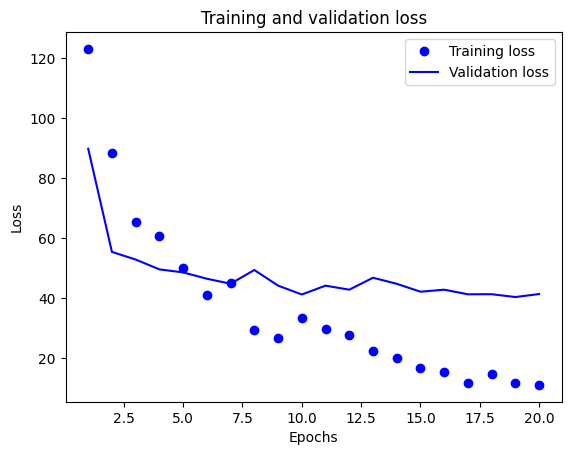

In [76]:
#plotting the training and validation loss
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [77]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [78]:
train_metric = 'accuracy'
val_metric = 'val_accuracy'

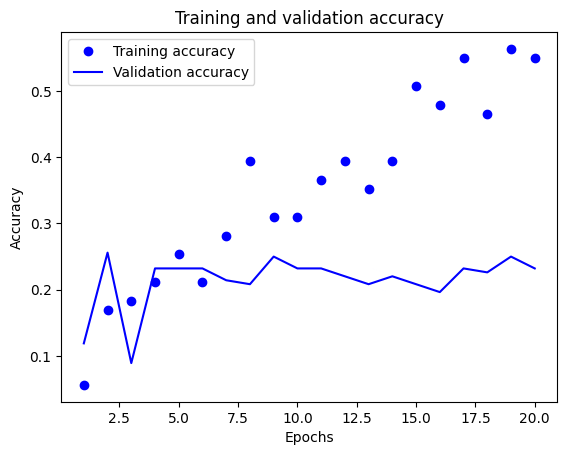

In [79]:
#plotting the training and validation accuracy
plt.clf()
acc = history.history[train_metric]
val_acc = history.history[val_metric]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [80]:
model.evaluate(test_padded, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1847 - loss: 28.6919


[27.988670349121094, 0.18333333730697632]

In [81]:
predictions = model.predict(test_padded)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [303]:
pred_list = []
for p in predictions:
   pred_list.append(p.argmax())

In [304]:
from sklearn.metrics import f1_score

In [305]:
f1_score(y_test, pred_list, average='micro')

0.2711864406779661

In [307]:
qa_df = pd.DataFrame({"text":X_test[keep].content.to_numpy(), 
              "true_value":le.inverse_transform(y_test), 
              "predicted_value": le.inverse_transform(pred_list)})

In [308]:
for row in qa_df.to_dict(orient="records"):
    if row["predicted_value"]!= "generic feedback":
        print(row["text"])
        print("True value:",row["true_value"])
        print("Predicted value:", row["predicted_value"])
        print("***********************")

1 star 🌟 till I've tried and tested the app myself
True value: Generic feedback
Predicted value: Features/Functionality
***********************
good
True value: Generic feedback
Predicted value: Generic feedback
***********************
This is the worst user friendly app. They claim there is no phone number to actually speak to someone. The people on the chat don't understand most issues, so you constantly have to repeat yourself. This app is incredibly bad with the lack of customer support especially.
True value: Customer Support
Predicted value: Customer Support
***********************
the bybt app is cool, but you guys need 2 upgrade on something, why wud a seller hold a buyer's transaction witout sending money, the buyer wud marked the transaction as sucesful without sendn the money, bcus of misunderstanding, that's not professional, cus u guys would @ the end tell the person 2 sort it out with the seller, knowing fully wel is not ethics, you guys shud upgrade knowing wen someone's